## Classificação
Este noteobook tem por objetivo gerar um csv com os dados sobre os comentários dos vídeos do canal Lion BBQ classificados.

In [1]:
! pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy
import pandas
import warnings
import joblib


from matplotlib import pyplot
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from operator import itemgetter
from wordcloud import WordCloud


In [4]:
pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_rows', None)
pandsa.set_option('display.max_colwidth', -1)

NameError: name 'pandsa' is not defined

In [5]:
folder = 'lion_bbq'
file_full = f'data_full_{folder}.csv'
train_data = 'croresid_labeled.csv'

In [8]:
data = pandas.read_csv(train_data)
data = data[~data['category'].isin(['ignorar'])]

In [9]:
data.head(1)

,video_title,author,comment,category,comment_cleaned,comment_stop_word,comment_tokenized,comment_stemming,comment_lematized,cluster
0,coments_of_Mini Festival Lion BBQ,José Roberto de Oliveira,Que Deus abençoe sempre a sua família!!! Parab...,água na boca,que deus abencoe sempre a sua familia parabens...,deus abencoe sempre familia parabens belo trab...,"['deus', 'abencoe', 'sempre', 'familia', 'para...","['deus', 'abenco', 'sempr', 'famil', 'parabens...","['deus', 'abencoe', 'sempre', 'familia', 'para...",14


## Modelo TFIDf

In [10]:
documents = data['comment_stemming'].astype('str').values


vectorizer = TfidfVectorizer(ngram_range=(1, 3),max_features=1500,min_df=5, max_df=0.8).fit(documents)
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.8, max_features=1500,
                min_df=5, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [11]:
vectorizer.transform(documents)

<644x272 sparse matrix of type '<class 'numpy.float64'>'
	with 4467 stored elements in Compressed Sparse Row format>

In [12]:
joblib.dump(vectorizer, 'vectorizer.joblib')

['vectorizer.joblib']

## Modelo de regressão logística

In [13]:
X = vectorizer.transform(documents)
y = data.category.values

oversample = RandomOverSampler(random_state=42)
X_over, y_over = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=42)

In [14]:
classifier = LogisticRegression(
    multi_class='ovr',
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
).fit(X_train, y_train)

classifier

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
joblib.dump(classifier, 'classifier.joblib')

['classifier.joblib']

In [16]:
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 José Almiro       0.93      0.96      0.94        52
      abraço       0.95      0.96      0.96        57
      bordão       0.96      0.88      0.92        59
     crítica       0.95      0.95      0.95        38
      duvida       0.94      0.80      0.87        56
      elogio       0.83      0.83      0.83        58
    sugestão       1.00      1.00      1.00        55
   vou fazer       0.98      1.00      0.99        61
       zuera       0.83      0.96      0.89        47
água na boca       0.95      0.98      0.97        60

    accuracy                           0.93       543
   macro avg       0.93      0.93      0.93       543
weighted avg       0.93      0.93      0.93       543



## Bigrama e Trigrama

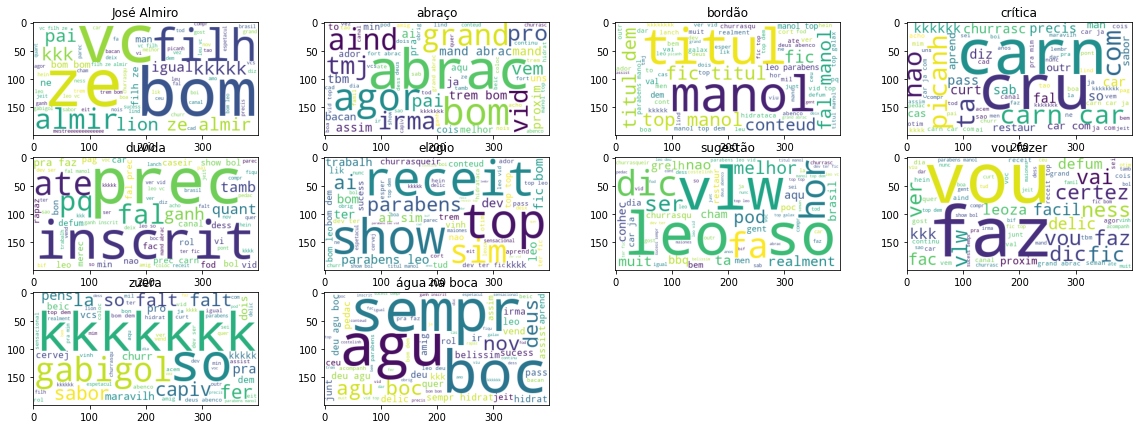

In [17]:
mw = 70
fig = pyplot.figure(figsize = (20, 12))

for i, v in enumerate(classifier.classes_):
    coefficients = classifier.coef_[i]
    keys = coefficients.argsort()[::-1][:mw]
    idx_to_word = {v: k for k, v in vectorizer.vocabulary_.items()}
    words = list(itemgetter(*keys)(idx_to_word))
    dictionary = {}
    d = 300
    for w in words:
        dictionary[w] = d
        d = d - 3

    wc = WordCloud(background_color='white', max_words=mw, relative_scaling=0.1, normalize_plurals=True)
    image = wc.generate_from_frequencies(dictionary)

    ax = fig.add_subplot(5, 4, (i + 1))
    pyplot.imshow(image)
    ax.set_title(v)

## Resultado com base real

In [18]:
real_data = pandas.read_csv(file_full)
real_data = real_data[~real_data['comment_stemming'].isna()]
real_data = real_data[['video_title', 
         'author', 
         'comment', 
         'comment_cleaned', 
         'comment_stop_word', 
         'comment_tokenized', 
         'comment_stemming',
         'comment_lematized']]

<AxesSubplot:ylabel='label'>

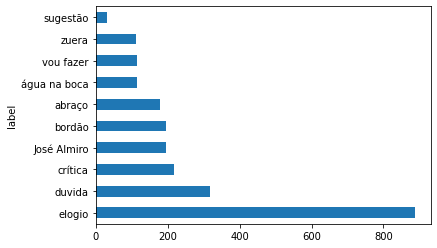

In [19]:
real_data['label'] = classifier.predict(vectorizer.transform(real_data.comment_stemming.values))
real_data.groupby(['label'])['author'].count().sort_values(ascending=False).plot.barh()

In [22]:
real_data.label.unique()

array(['duvida', 'água na boca', 'elogio', 'zuera', 'José Almiro',
       'abraço', 'vou fazer', 'crítica', 'bordão', 'sugestão'],
      dtype=object)

In [129]:
real_data.to_csv(f'data_full_{folder}_classified.csv', sep=',', encoding='utf-8', index=False)